In [1]:
import pandas as pd
import numpy as np
import random
import math
from numpy import random
import cmath
import matplotlib.pyplot as plt

In [2]:
# Load datasets related to Base Stations, UAVs, and Clients
base = pd.read_csv(r'BS_data.csv')
uav = pd.read_csv(r'UAV_data.csv')
people = pd.read_csv(r'people_data.csv')
IRS=pd.read_csv(r'IRS_data.csv')
p_km_UP=pd.read_csv(r'P_km_up.csv')

Angle_df=pd.read_csv(r'Angle.csv') # number of IRS is 500 store in each column
h_l_km_df=pd.read_csv(r'h_l_km.csv') # number of IRS is 500 store in each column
h_l_m_df=pd.read_csv(r'h_l_m.csv') # number of IRS is 500 store in each column

Angle_UP_df=pd.read_csv(r'Angle1.csv') # number of IRS is 500 store in each column
g_l_km_df=pd.read_csv(r'h_l_km1.csv') # number of IRS is 500 store in each column
g_l_m_df=pd.read_csv(r'h_l_m1.csv') # number of IRS is 500 store in each column # corrected filename

Angle_har_df=pd.read_csv(r'Angle2.csv') # number of IRS is 500 store in each column
f_l_km_df=pd.read_csv(r'h_l_km2.csv') # number of IRS is 500 store in each column
f_l_m_df=pd.read_csv(r'h_l_m2.csv') # number of IRS is 500 store in each column # corrected filename
f_km1=pd.read_csv(r'f_km.csv')

In [3]:
# Constants
Wl = 35.28
H_value= 20
P_m_har = base['P_m_har']
T_m_har = base['T_m_har']
P_m_down = base['P_m_down']
f_km=f_km1['0']
V_lm_vfly = uav['V_lm_vfly']
V_lm_hfly = uav['V_lm_hfly']
D_l_hfly = 100

P_km_up=p_km_UP['0']
p_max=10 # moved inside loop
p_km_max=10
T_m=10
D_m_current=0.49


# Additional constants for calculations
delta = 0.012
Ar = 0.1256
s = 0.05
Nr = 4
V_tip = 102
Cd = 0.022
Af = 0.2113
D_km = 0.5
# Dm=0.49
B=10 #MHz
sigma_km=10**(-13)
eta=10
kappa=0.5
num_population=50
Bh = (1 - 2.2558 * pow(10, -5) *H_value)**4.2577
# Bh = max(1, Bh)
p_l_b = (delta / 8) * Bh * Ar * s * pow(V_tip, 3)

In [4]:
# Determine the maximum possible rows based on the smallest dataframe size
min_rows = min(len(Angle_df), len(h_l_km_df), len(h_l_m_df), len(Angle_UP_df), len(g_l_km_df), len(g_l_m_df), len(Angle_har_df), len(f_l_km_df), len(f_l_m_df), len(f_km1))
num_rows_data_files = min_rows # Dynamically set num_rows_data_files based on the smallest dataframe length
population_size = min(50, num_rows_data_files) # Ensure population_size is not larger than available data

In [5]:
# Fitness function to calculate total energy consumption
def Fitness(E_ml_har, E_ml_down, E_ml_UAV):
    return E_ml_har + E_ml_down + E_ml_UAV

# Energy consumption of the UAV-IRS
def E_ml_UAV(P_l_vfly, T_l_vfly, P_lm_hfly, T_l_hfly, P_l_hov, T_lm_hov):
    return P_l_vfly * T_l_vfly + P_lm_hfly * T_l_hfly + P_l_hov * T_lm_hov

# Power calculations for different flight modes
def P_l_vfly(Wl, V_l_vfly, P_l_b, Nr, Ar, Bh):
    temp2 = Nr * Bh * Ar
    temp3 = np.sqrt(V_l_vfly**2 + (2 * Wl) / temp2)
    return ((Wl / 2) * (V_l_vfly + temp3)) + Nr * P_l_b

def P_lm_hfly(P_lm_blade, P_lm_fuselage, P_lm_induced):
    return P_lm_blade + P_lm_fuselage + P_lm_induced

def P_lm_blade(Nr, P_l_b, V_tip, V_lm_hfly):
    return Nr * P_l_b * (1 + ((3 * (V_lm_hfly**2)) / pow(V_tip, 2)))

def P_lm_fuselage(Cd, Af, Bh, V_lm_hfly):
    return (1 / 2) * Cd * Af * Bh * (V_lm_hfly**3)

def P_lm_induced(Nr, Bh, Ar, Wl, V_lm_hfly):
    return Wl * ((np.sqrt((Wl**2) / (4 * (Nr**2) * (Bh**2) * (Ar**2)) + ((V_lm_hfly**4) / 4)) - ((V_lm_hfly**2) / 2))**(1 / 2))

def P_l_hov(Wl, P_l_b, Nr, Ar, Bh):
    temp1 = Nr * P_l_b
    temp3 = np.sqrt(2 * (Nr * Bh * Ar))
    temp4 = ((Wl)**3 / 2) / temp3
    return temp1 + temp4

def T_lm_hov(T_km_com, T_kml_up, T_ml_down):
    return T_km_com + T_kml_up + T_ml_down

def R_ml_down(B,P_m_down,h_ml_worst): #eqation number 7
    temp1=(h_ml_worst*P_m_down) # Consider if min is the correct aggregation. It should be multiplication
    if (1+temp1) <= 0:
        return 0  # Return 0 if log argument is non-positive to avoid error
    return B*math.log2(1+temp1)

def h_ml_worst(h_kml_down,sigma_km): #eqation number 8
    return h_kml_down/(sigma_km) # it will return the sigal value which is minimum of all
            # the value for each itaration

def calculate_exp_i_theta(theta): # part of equation 8
  return cmath.exp(1j * theta)
 # 1j represents the imaginary unit in Python

def h_kml_down(Angle,h_l_m,h_l_km): # part of equation 8
    result=[]
    if isinstance(Angle, float): # Check if Angle is float, if so, return 0 or handle appropriately
        return 0 # Or raise an exception or return a default value as needed

    if not isinstance(Angle, pd.Series): # added check to handle non-series input
        raise TypeError(f"Expected Angle to be pd.Series, got {type(Angle)}")

    for i in range(len(Angle)):
        theta_radians = math.radians(Angle.iloc[i]) # Use iloc for position-based indexing
        results= calculate_exp_i_theta(theta_radians)
        result.append(results)

    diagonal=np.diag(result)
    # Ensure h_l_m and h_l_km are correctly formatted as numpy arrays
    h_l_m_np = h_l_m.to_numpy() # Convert Series to numpy array
    h_l_km_np = h_l_km.to_numpy() # Convert Series to numpy array
    if h_l_m_np.ndim == 1:
        h_l_m_np = h_l_m_np.reshape(-1, 1) # Reshape to 2D if necessary
    if h_l_km_np.ndim == 1:
        h_l_km_np = h_l_km_np.reshape(1, -1) # Reshape to 2D if necessary


    a=np.dot(h_l_km_np,diagonal) # Use numpy arrays for dot product
    b=np.dot(a,h_l_m_np)      # Use numpy arrays for dot product
    final=abs(b[0][0]) # Take absolute value and ensure it's a scalar
    return (final**2)

def R_kml_up(B,P_km_up,h_kml_up,Sub,sigma_m): #eqation number 4
    temp1=(P_km_up*h_kml_up)/ (Sub+(sigma_m))
    return B*math.log2(1+temp1)
#this is inside the equation 4 have to take summation of h_i_up and P_i_up
def sub(P_i_up,h_il_up):
    return P_i_up*h_il_up

def E_km_com(f_km,T_km_com):
    return eta*(10**(-28))*(f_km**3)*T_km_com

def E_kml_up(P_km_up,T_km_up):
    return P_km_up*T_km_up

def E_kml_har(P_m_har,T_m_har,h_km_har):
    return kappa*P_m_har*T_m_har*h_km_har

In [ ]:
num_bs = 5
num_irs_ele=50
num_generation = 10 # Number of iterations for Hill Climbing
num_uav_irs = 8
population_size = 50 # Initial population size (used for initial solution in HC)

# Define keys that should be subjected to perturbation (numerical parameters)
numerical_keys_for_hc = [
    'P_m_down_value', 'P_m_har_value', 'T_m_har_value',
    'f_km_value', 'V_lm_vfly_value', 'V_lm_hfly_value',
    'P_km_up_value','Angle1_row','Angle_row','Angle2_row',
]


fitness_sums_HC = [] # Store sum of fitness values for each p_max

all_best_combinations = []
all_best_individuals = []

# Main Hill Climbing Algorithm Loop
for l in range(num_bs):
    all_best_individuals_bs = []
    P_m_har_value = P_m_har.values[l]
    T_m_har_value = T_m_har.values[l]
    P_m_down_value = P_m_down.values[l]

    # Select unique row indices for the current BS
    index_list = list(range(num_rows_data_files)) # Create a list of all indices
    random.shuffle(index_list)
    unique_row_indices = index_list[:population_size] # use population size to pick initial indices
    # Create dataframes with uniquely selected rows for the current BS
    h_l_km_df_bs = h_l_km_df.iloc[unique_row_indices, :].reset_index(drop=True)
    g_l_km_df_bs = g_l_km_df.iloc[unique_row_indices, :].reset_index(drop=True)
    f_l_km_df_bs = f_l_km_df.iloc[unique_row_indices, :].reset_index(drop=True)
    f_km_bs = f_km[unique_row_indices].reset_index(drop=True)
    # Corrected line: Ensure indices are within bounds of P_km_up
    valid_indices = [i for i in unique_row_indices if i < len(P_km_up)]
    P_km_up_bs = P_km_up.iloc[valid_indices].reset_index(drop=True)


    for k in range(num_uav_irs):
        best_fitness = float('inf')
        best_individual = {}

        V_lm_vfly_value = V_lm_vfly.values[k]
        V_lm_hfly_value = V_lm_hfly.values[k]
        D_l_hfly_value = D_l_hfly
        Wl_value = Wl
        Sub_value=0
        # Corrected loop range to use valid_indices length
        for i in range(len(valid_indices)): # Using length of valid_indices
            h_il_up_value=h_kml_down(Angle_UP_df.iloc[i, :],g_l_m_df.iloc[k, :],g_l_km_df_bs.iloc[i, :]) # Pass Series, corrected index to i
            Sub_value+=sub(P_km_up_bs[i],h_il_up_value)

        # Initialize initial solution for Hill Climbing - using first from 'population initialization' of GA
        initial_solution_data = {}
        i=0 # Using first index for initialization
        f_km_value = f_km_bs[i] # Use BS-specific f_km
        P_km_up_value = P_km_up_bs[i] # Use BS-specific P_km_up

        Angle_row = Angle_df.iloc[i, :] # Use BS-specific Angle_df
        h_l_m_row = h_l_m_df.iloc[k, :] # Use BS-specific h_l_m_df
        h_l_km_row = h_l_km_df_bs.iloc[i, :] # Use BS-specific h_l_km_df
        Angle1_row = Angle_UP_df.iloc[i, :] # Use BS-specific Angle_UP_df
        g_l_m_row = g_l_m_df.iloc[k, :] # Use BS-specific g_l_m_df
        g_l_km_row = g_l_km_df_bs.iloc[i, :] # Use BS-specific g_l_km_df
        Angle2_row = Angle_har_df.iloc[i, :] # Use BS-specific Angle_har_df
        f_l_m_row = f_l_m_df.iloc[k, :] # Use BS-specific f_l_m_df
        f_l_km_row = f_l_km_df_bs.iloc[i, :] # Use BS-specific f_l_km_df



        # Calculate power values
        P_lm_blade_value = P_lm_blade(Nr, p_l_b, V_tip, V_lm_hfly_value)
        P_lm_fuselage_value = P_lm_fuselage(Cd, Af, Bh, V_lm_hfly_value)
        P_lm_induced_value = P_lm_induced(Nr, Bh, Ar, Wl_value, V_lm_vfly_value)

        # Calculate time and energy values
        T_l_vfly_value = H_value / V_lm_vfly_value
        T_l_hfly_value = D_l_hfly_value / V_lm_hfly_value # Corrected: D_l_hfly / V_lm_hfly
        E_ml_har_value = P_m_har_value * T_m_har_value
        h_kml_down_value=h_kml_down(Angle_row,h_l_m_row,h_l_km_row) # Pass Series
        h_ml_worst_value=h_ml_worst(h_kml_down_value,sigma_km)
        R_ml_down_value=R_ml_down(B,P_m_down_value,h_ml_worst_value)
        T_ml_down_value=D_m_current/R_ml_down_value
        E_ml_down_value = P_m_down_value * T_ml_down_value
        T_km_com_value = D_km / f_km_value
        h_kml_up_value=h_kml_down(Angle1_row,g_l_m_row,g_l_km_row) # Pass Series, using same function, might need different one if logic is different

        R_kml_up_value=R_kml_up(B,P_km_up_value,h_kml_up_value,Sub_value,sigma_km)
        T_km_up_value=D_m_current/R_kml_up_value # equation number 5
        T_lm_hov_value = T_lm_hov(T_km_com_value, T_km_up_value, T_ml_down_value)
        P_l_hov_value = P_l_hov(Wl_value, p_l_b, Nr, Ar, Bh)
        P_l_vfly_value = P_l_vfly(Wl_value, V_lm_vfly_value, p_l_b, Nr, Ar, Bh)
        P_lm_hfly_value = P_lm_hfly(P_lm_blade_value, P_lm_fuselage_value, P_lm_induced_value)
        E_ml_UAV_value = E_ml_UAV(P_l_vfly_value, T_l_vfly_value, P_lm_hfly_value, T_l_hfly_value, P_l_hov_value, T_lm_hov_value)

        # Calculate fitness for initial solution
        initial_fitness = Fitness(E_ml_har_value, E_ml_down_value, E_ml_UAV_value)

        current_solution = {
            'fitness': initial_fitness,
            'data': {
                'P_m_down_value': P_m_down_value,
                'P_m_har_value': P_m_har_value,
                'T_m_har_value': T_m_har_value,
                'f_km_value': f_km_value,
                'V_lm_vfly_value': V_lm_vfly_value,
                'V_lm_hfly_value': V_lm_hfly_value,
                'P_km_up_value':P_km_up_value,
                'Angle1_row':Angle1_row,
                'Angle_row':Angle_row,
                'Angle2_row': Angle2_row,
            }
        }
        best_individual = current_solution
        best_fitness = initial_fitness


        generations_data = []
        for j in range(num_generation): # Hill Climbing iterations
            # Generate neighbor solution by perturbing the current solution
            neighbor_solution_data = current_solution['data'].copy() # Correct: Copy current solution data


            for i in range(10): # You can keep this loop if it's intended for repeated perturbations per generation
                for key in numerical_keys_for_hc:
                    # Apply mutation only to numerical keys
                    if key in ['Angle1_row','Angle_row','Angle2_row']: # Handle Angle Series
                        # --- REMOVED: neighbor_solution_data[key] = pd.Series(index=Angle_df.columns, dtype='float64') --- # PROBLEM LINE REMOVED
                        for col in Angle_df.columns: # Iterate through each column (angle direction)
                            neighbor_solution_data[key][col] += random.normal(loc=0, scale=1, size=(1))[0] # Perturb EXISTING value
                            if neighbor_solution_data[key][col] < 0: # Check if the RESULTING angle is negative
                                neighbor_solution_data[key][col] = abs(neighbor_solution_data[key][col]) # Take abs value of the RESULT

                    else:
                        neighbor_solution_data[key] += random.normal(loc=0, scale=1, size=(1))[0] # Reduced scale for smaller perturbations in HC


                # Compute neighbor fitness (rest of your code remains the same)
                def compute_fitness(data): # Define compute_fitness WITHIN the generation loop - scope is fine here
                    P_m_down_value = data['P_m_down_value']
                    P_m_har_value = data['P_m_har_value']
                    T_m_har_value = data['T_m_har_value']
                    f_km_value = data['f_km_value']
                    V_lm_vfly_value = data['V_lm_vfly_value']
                    V_lm_hfly_value = data['V_lm_hfly_value']
                    P_km_up_value=data['P_km_up_value']
                    Angle_row = data['Angle_row'] # Retrieve angle row from neighbor data
                    Angle1_row = data['Angle1_row'] # Retrieve angle row from neighbor data
                    Angle2_row = data['Angle2_row'] # Retrieve angle row from neighbor data

                    # Calculate power values
                    P_lm_blade_value = P_lm_blade(Nr, p_l_b, V_tip, V_lm_hfly_value)
                    P_lm_fuselage_value = P_lm_fuselage(Cd, Af, Bh, V_lm_hfly_value)
                    P_lm_induced_value = P_lm_induced(Nr, Bh, Ar, Wl_value, V_lm_vfly_value)

                    # Calculate time and energy values
                    T_l_vfly_value = H_value / V_lm_vfly_value
                    T_l_hfly_value = D_l_hfly_value / V_lm_hfly_value # Corrected: D_l_hfly / V_lm_hfly
                    E_ml_har_value = P_m_har_value * T_m_har_value # Corrected:

                    h_kml_down_value_compute=h_kml_down(Angle_row,h_l_m_row,h_l_km_row) # Using original Angle_row, h_l_m_row, h_l_km_row for neighbor as well - might need to be based on neighbor data if angles are also part of optimization
                    h_ml_worst_value=h_ml_worst(h_kml_down_value_compute,sigma_km)
                    R_ml_down_value=R_ml_down(B,P_m_down_value,h_ml_worst_value)
                    if R_ml_down_value <= 0: # check if R_ml_down_value is zero or negative
                        R_ml_down_value = 1e-9 # Assign a small positive value to avoid division by zero
                    T_ml_down_value=D_m_current/R_ml_down_value
                    E_ml_down_value = P_m_down_value * T_ml_down_value
                    T_km_com_value = D_km / f_km_value

                    h_kml_up_value=h_kml_down(Angle1_row,g_l_m_row,g_l_km_row) # Pass Series, using same function, might need different one if logic is different
                    R_kml_up_value=R_kml_up(B,P_km_up_value,h_kml_up_value,Sub_value,sigma_km)
                    T_km_up_value=D_m_current/R_kml_up_value # equation number 5

                    T_lm_hov_value = T_lm_hov(T_km_com_value, T_km_up_value, T_ml_down_value)
                    P_l_hov_value = P_l_hov(Wl_value, p_l_b, Nr, Ar, Bh)
                    P_l_vfly_value = P_l_vfly(Wl_value, V_lm_vfly_value, p_l_b, Nr, Ar, Bh)
                    P_lm_hfly_value = P_lm_hfly(P_lm_blade_value, P_lm_fuselage_value, P_lm_induced_value)
                    E_ml_UAV_value = E_ml_UAV(P_l_vfly_value, T_l_vfly_value, P_lm_hfly_value, T_l_hfly_value, P_l_hov_value, T_lm_hov_value)
                    h_kml_har_value_compute=h_kml_down(Angle2_row,f_l_m_row,f_l_km_row) # Corrected index to Angle2_row
                    E_kml_har_value=E_kml_har(P_m_har_value,T_m_har_value,h_kml_har_value_compute) # Corrected function call for E_kml_har
                    E_kml_com_value = E_km_com(f_km_value, T_km_com_value)
                    E_kml_up_value=E_kml_up(P_km_up_value,T_km_up_value)


                    # Calculate fitness
                    fitness_value = Fitness(E_ml_har_value, E_ml_down_value, E_ml_UAV_value)
                    current_data = {
                        'P_m_down_value': P_m_down_value,
                        'P_m_har_value': P_m_har_value,
                        'T_m_har_value': T_m_har_value,
                        'f_km_value': f_km_value,
                        'V_lm_vfly_value': V_lm_vfly_value,
                        'V_lm_hfly_value': V_lm_hfly_value,
                        'P_km_up_value':P_km_up_value,
                        'Angle1_row':Angle1_row,
                        'Angle_row':Angle_row,
                        'Angle2_row': Angle2_row, # Carry forward original index
                                                            }
                    if V_lm_hfly_value>0 and T_m_har_value>0 and T_ml_down_value>0 and T_km_up_value>0 and P_m_har_value<=p_max and P_m_down_value<=p_max and P_km_up_value<=p_km_max and (T_km_com_value+T_km_up_value+T_ml_down_value)<=T_m and f_km_value>0  and E_kml_har_value>=(E_kml_up_value+E_kml_com_value) and V_lm_vfly_value>0:
                        return fitness_value, current_data
                    else:
                        return  float('inf'),{} # Return empty dict instead of float('inf') for data


                neighbor_fitness, neighbor_data1 = compute_fitness(neighbor_solution_data)


                # Decide whether to accept the neighbor
                if neighbor_fitness < current_solution['fitness']: # Assuming minimization
                    current_solution = {'fitness': neighbor_fitness, 'data': neighbor_data1}


            generations_data.append(current_solution.copy()) # Append the *updated* current_solution

        best_individual_pair = current_solution.copy()
        best_individual_pair['generation'] = j + 1 # Use last j from loop, corrected index
        best_individual_pair['type'] = 'HC'
        best_individual_pair['bs_index'] = l
        best_individual_pair['uav_index'] = k
        all_best_individuals_bs.append(best_individual_pair)

        all_best_combinations.append({
            'bs_index': l,
            'uav_index': k,
            'best_fitness': current_solution['fitness'],
            'best_individual': best_individual_pair,
            'generation_fitness': [gen['fitness'] for gen in generations_data],
            'unique_row_indices': unique_row_indices # Store unique_row_indices in best_combinations
        })
        # print(f"Best Fitness for BS {l}, UAV {k}: {current_solution['fitness']:.4f}")

    # Find best individual for current BS across all UAVs
    best_individual_for_bs = min(all_best_individuals_bs, key=lambda x: x['fitness'])
    # print(f"Best Fitness for BS {l} across all UAVs: {best_individual_for_bs['fitness']:.4f}")


# Select the best unique Base station and UAV-IRS pair using Auction based method
combination_lookup = {}
for combination in all_best_combinations:
    if combination['bs_index'] not in combination_lookup:
        combination_lookup[combination['bs_index']] = {}
    combination_lookup[combination['bs_index']][combination['uav_index']] = combination

# Auction-based assignment
best_assignments = []
unassigned_bs = list(range(num_bs))
unassigned_uavs = list(range(num_uav_irs))

while unassigned_bs and unassigned_uavs:
    best_combination_overall = None

    for l in unassigned_bs:
        best_fitness_for_bs = float('inf')
        best_combination_for_bs = None
        for k in unassigned_uavs:
            if l in combination_lookup and k in combination_lookup[l]:
                combination = combination_lookup[l][k]
                if combination['best_fitness'] < best_fitness_for_bs: # Use 'best_fitness' instead of 'best_individual']['fitness']
                    best_fitness_for_bs = combination['best_fitness']
                    best_combination_for_bs = combination

        if best_combination_for_bs:
            if best_combination_overall is None or best_combination_for_bs['best_fitness'] < best_combination_overall['best_fitness']: # Compare with current best overall
                best_combination_overall = best_combination_for_bs

    if best_combination_overall:
        best_assignments.append(best_combination_overall)
        unassigned_bs.remove(best_combination_overall['bs_index'])
        unassigned_uavs.remove(best_combination_overall['uav_index'])

# # Print and Plotting
print(f"\n--- Best Unique UAV Assignments (Auction Based Method) using Hill Climbing ---")
best_pair_for_plot = None
min_fitness_for_plot = float('inf')

sum_fitness_current_p_max = 0 # Sum of best fitness for current p_max
for assignment in best_assignments:
    print(f"\nBest Assignment for BS {assignment['bs_index']}:")
    print(f" UAV Index: {assignment['uav_index']}")
    best_ind = assignment['best_individual']
    print(f" Best Individual:")
    print(f"  Generation: {best_ind['generation']}, Type: {best_ind['type']}")
    print(f"  Fitness: {best_ind['fitness']:.4f}") # Print current best fitness only
    unique_indices_to_print = assignment['unique_row_indices'] # Retrieve unique_row_indices
    for key, value in best_ind['data'].items():
        if isinstance(value, pd.Series):
            print(f"  {key}: Series: \n{value.iloc[unique_indices_to_print]}") # Print sliced Series
        elif isinstance(value, list): # Handle list type values explicitly
            print(f"  {key}: {value}") # print list directly without formatting
        else:
            print(f"  {key}: {value:.4f}") # Format scalar values

    print("-" * 20)
    sum_fitness_current_p_max += best_ind['fitness'] # Sum fitness values

    if assignment['best_individual']['fitness'] < min_fitness_for_plot:
        min_fitness_for_plot = assignment['best_individual']['fitness']
        best_pair_for_plot = assignment

fitness_sums_HC.append(sum_fitness_current_p_max) # Store sum of fitness for this p_max

# Unassigned BS/UAVs
if unassigned_bs:
    print("\n--- Base Stations without Assigned UAVs ---")
    for bs_index in unassigned_bs:
        print(f"  BS {bs_index} : No UAV is assigned")
        print("-" * 20)

if unassigned_uavs:
    print("\n--- UAVs without Assigned Base Stations ---")
    for uav_index in unassigned_uavs:
        print(f"  UAV {uav_index} : No BS is assigned")
        print("-" * 20)


--- Best Unique UAV Assignments (Auction Based Method) using Hill Climbing ---

Best Assignment for BS 0:
 UAV Index: 6
 Best Individual:
  Generation: 10, Type: HC
  Fitness: 19883.4220
  P_m_down_value: 0.4056
  P_m_har_value: 1.4742
  T_m_har_value: 5.3929
  f_km_value: 11.5721
  V_lm_vfly_value: 98.7014
  V_lm_hfly_value: 28.2239
  P_km_up_value: 9.8983
  Angle1_row: Series: 
165    269.743783
35      23.413843
72      51.060184
223    194.441259
342     91.808737
88     172.211132
383    125.105888
253    114.853689
22     133.061568
452     14.862068
467     61.863920
247     62.561281
385    213.408868
111    110.784911
124    151.040226
157     92.329451
186    144.703636
68      46.289691
77     112.510849
244    159.282626
17       4.713021
271     71.950786
78     102.575170
104    101.550386
451     89.945277
207    119.837901
265     34.545616
317     26.024064
498     67.566048
42     112.243545
408     48.572710
229    100.753564
65      23.398444
9        1.564591
460 

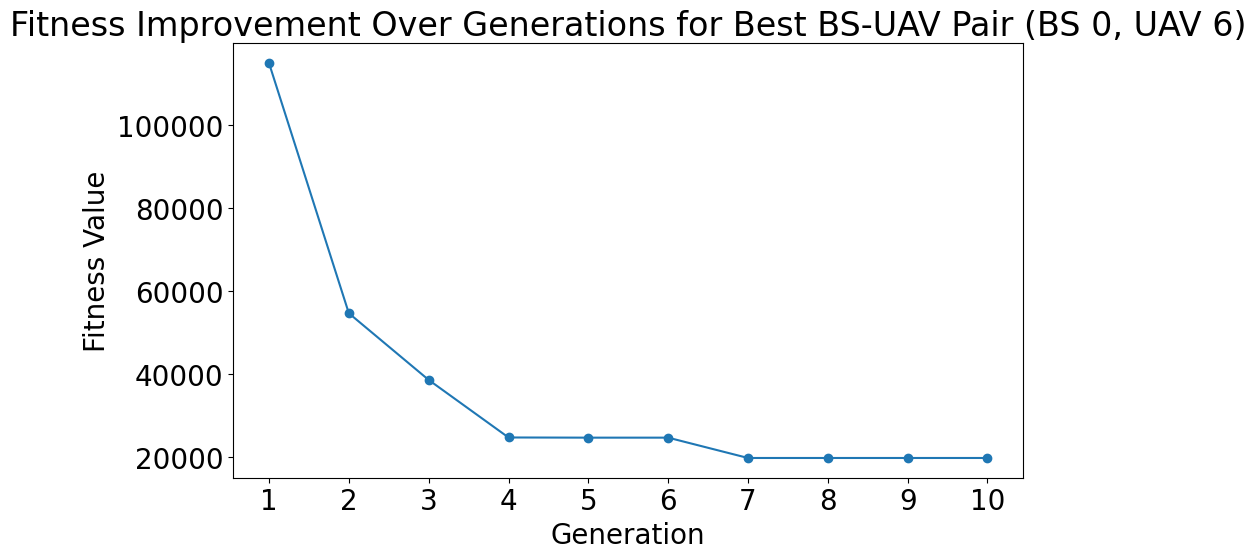

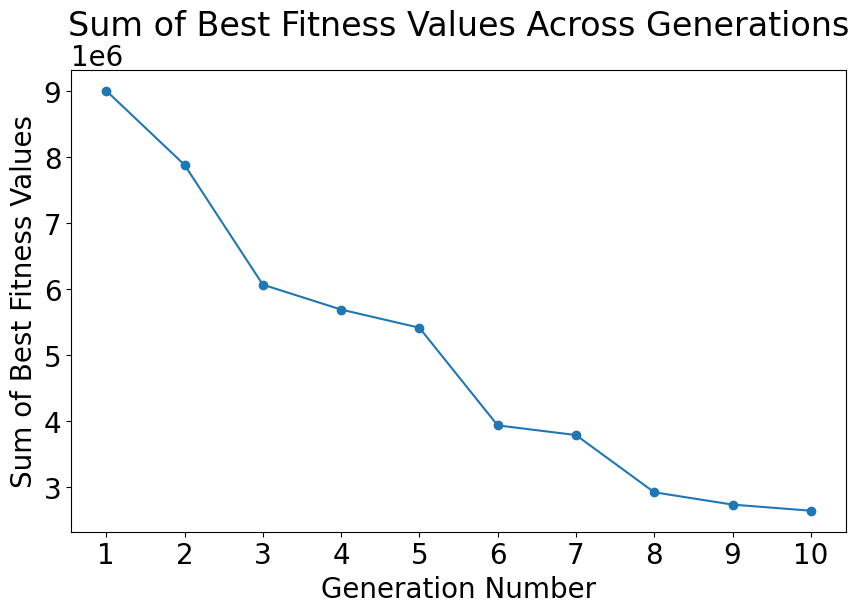

In [7]:
# Plotting graphs
if best_pair_for_plot:
    fitness_history_best_pair = best_pair_for_plot['generation_fitness']
    generations = range(1, num_generation + 1)

    plt.figure(figsize=(10, 6))
    plt.rcParams["font.size"]=20
    plt.plot(generations, fitness_history_best_pair, marker='o', linestyle='-')
    plt.xlabel('Generation')
    plt.ylabel('Fitness Value')
    plt.title(f'Fitness Improvement Over Generations for Best BS-UAV Pair (BS {best_pair_for_plot['bs_index']}, UAV {best_pair_for_plot['uav_index']})')
    plt.xticks(generations)
    plt.tight_layout()
    plt.show()
else:
    print("\nNo best pair found for plotting.")

# Sum of Best Fitness Values Across Generations
best_pair_combination = min(all_best_combinations, key=lambda x: x['best_fitness'])
best_bs_index_plot = best_pair_combination['bs_index']
best_uav_index_plot = best_pair_combination['uav_index']

generations = []
fitness_values = []

sum_fitness_per_generation = [0] * num_generation
for gen_idx in range(num_generation):
    generation_sum = 0
    for combination in all_best_combinations:
        generation_sum += combination['generation_fitness'][gen_idx]
    sum_fitness_per_generation[gen_idx] = generation_sum

generation_indices = list(range(1, num_generation + 1))

plt.figure(figsize=(10, 6))
plt.rcParams["font.size"] = "20"
plt.plot(generation_indices, sum_fitness_per_generation, marker='o', linestyle='-')
plt.title('Sum of Best Fitness Values Across Generations')
plt.xlabel('Generation Number')
plt.ylabel('Sum of Best Fitness Values')
plt.xticks(generation_indices)
plt.show()

